In [5]:
from preamble import *

## 데이터 불러오기

load_files 클래스는 폴더의 파일을 불러온다. 폴더는 알파벳 순서에 따라 레이블로 구분된다. neg 폴더의 데이터는 0, pos 폴더의 데이터는 1이 된다.

In [10]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
reviews_test = load_files('data/aclImdb/test/')
text_train, y_train = reviews_train.data, reviews_train.target
text_test, y_test = reviews_test.data, reviews_test.target

print('text_train 길이:', len(text_train))
print('text_test 길이:', len(text_test))
print('text_train 샘플\n', text_train[0])
print('text_test 샘플\n', text_test[0])

text_train 길이: 25000
text_test 길이: 25000
text_train 샘플
 b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."
text_test 샘플
 b"Don't hate Heather Graham because she's beautiful, hate her because she's fun to watch in this movie. Like the hip clothing and funky surroundings, the actors i

In [11]:
print('<br /> 태그 삭제')
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

<br /> 태그 삭제


In [12]:
print('클래스별 샘플 수 (훈련 데이터):', np.bincount(y_train))
print('클래스별 샘플 수 (테스트 데이터):', np.bincount(y_test))

클래스별 샘플 수 (훈련 데이터): [12500 12500]
클래스별 샘플 수 (테스트 데이터): [12500 12500]


## 텍스트 -> BOW

- BOW(Bag of words): 각 문서에서 나타난 단어의 횟수가 담긴 하나의 벡터를 반환
    1. 토큰화: 각 문서를 문서에 포함된 단어로 나눔(공백이나 구두점 기준)
    1. 어휘 사전 구축: 모든 문서에 나타난 모든 단어의 어휘를 모으고 알파벳 순서로 번호 매김
    1. 인코딩: 어휘 사전의 단어가 문서에 몇 번 나타나는지 헤아림
- sklearn.feature_extraction.text -> CountVectorizer fit : 데이터를 토큰으로 나누고 어휘 사전을 구축하여 vocabulary_ 속성에 저장
- CountVectorizer transform : 어휘 사전의 단어가 문장에서 몇 번 나타나는지 숫자로 표시 -> 0이 아닌 값만 저장하는 SciPy 희소 행렬

In [27]:
# repr() : 객체를 문자열로 반환하는 함수
# 설명: https://wikidocs.net/134994
# min_df : 토큰이 나타날 최소 문서 개수
# stop_words=english : 불용어 제거 -> 큰 효과는 없음
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
print('X_trian:\n', repr(X_train))

X_trian:
 <25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [28]:
feature_names = vect.get_feature_names_out()
print('특성 개수:', len(feature_names))
print('처음 20개 특성:\n', feature_names[:20])
print('20010에서 20030까지 특성:\n', feature_names[20010:20030])
print('매 2000번째 특성:\n', feature_names[::2000])

특성 개수: 26966
처음 20개 특성:
 ['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103']
20010에서 20030까지 특성:
 ['resume' 'resumed' 'resumes' 'resurgence' 'resurrect' 'resurrected'
 'resurrecting' 'resurrection' 'resurrects' 'retail' 'retain' 'retained'
 'retaining' 'retains' 'retakes' 'retaliate' 'retaliation' 'retard'
 'retarded' 'retards']
매 2000번째 특성:
 ['00' 'balls' 'champions' 'damages' 'empathy' 'gaunt' 'immersive'
 'librarians' 'mythic' 'pleas' 'restriction' 'sleep' 'tenacity'
 'vulnerable']


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, n_jobs=-1)
print('교차 검증 평균 점수: {:.2f}'.format(np.mean(scores)))

교차 검증 평균 점수: 0.88


In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
print('최상의 교차 검증 평균 점수: {:.2f}'.format(grid.best_score_))
print('최적의 매개변수: ', grid.best_params_)

최상의 교차 검증 평균 점수: 0.88
최적의 매개변수:  {'C': 0.1}


In [31]:
X_test = vect.transform(text_test)
print('테스트 점수: {:.2f}'.format(grid.score(X_test, y_test)))

테스트 점수: 0.87


## tf-idf로 데이터 스케일 변경

tf-idf(term frequency-inverse document frequency, 단어빈도-역문서빈도) : 다른 문서보다 특정 문서에 자주 나타나는 단어에 높은 가중치를 주는 방법. 한 단어가 특정 문서에 자주 나타나고 다른 여러 문서에서 그렇지 않다면 그 문서의 내용을 아주 잘 설명하는 단어라고 보는 것

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print('최상의 교차 검증 평균 점수: {:.2f}'.format(grid.best_score_))

최상의 교차 검증 평균 점수: 0.89


- 낮은/높은 tf-idf 단어 
- idf 값이 낮은 단어: 자주 나타나서 덜 중요하다고 생각되는 단어

In [33]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vectorizer.transform(text_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print('가장 낮은 tfidf를 가진 특성:\n', feature_names[sorted_by_tfidf[:20]])
print('가장 높은 tfidf를 가진 특성:\n', feature_names[sorted_by_tfidf[-20:]])

가장 낮은 tfidf를 가진 특성:
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
가장 높은 tfidf를 가진 특성:
 ['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


In [34]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print('가장 낮은 idf를 가진 특성:\n', feature_names[sorted_by_idf[:100]])

가장 낮은 idf를 가진 특성:
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## 모델 계수 확인

로지스틱 회귀의 가장 큰 계수 40개와 가장 작은 계수 40개 출력

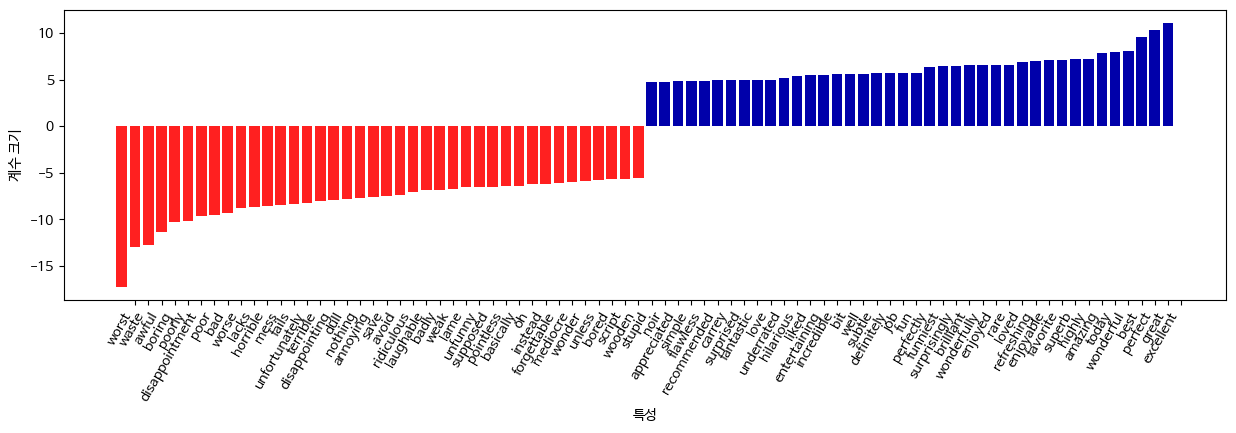

In [36]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_[0], feature_names, n_top_features=40)

## 여러 단어로 만든 BOW (n-그램)

- n-gram : 연속된 토큰
- CountVectorizer(ngram_range=(1, 1)) : 최소 길이가 1이고 최대 길이가 1인 토큰을 하나의 특성으로 만듦

In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print('최상의 교차 검증 점수: {:.2f}'.format(grid.best_score_))
print('최상의 매개변수:\n', grid.best_params_)

## KoNLPy

In [6]:
df_train = pd.read_csv('data/ratings_train.txt', delimiter='\t', keep_default_na=False)
df_test = pd.read_csv('data/ratings_test.txt', delimiter='\t', keep_default_na=False)
text_train, y_train = df_train['document'].values, df_train['label'].values
text_test, y_test = df_test['document'].values, df_test['label'].values

In [41]:
from konlpy.tag import Okt

class PicklableOkt(Okt):

    def __init__(self, *args):
        self.args = args
        Okt.__init__(self, *args)
    
    def __setstate__(self, state):
        self.__init__(*state['args'])

    def __getstate__(self):
        return {'args': self.args}

okt = PicklableOkt()

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {'tfidfvectorizer__min_df': [3, 5, 7],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'logisticregression__C': [0.1, 1, 10]}
pipe = make_pipeline(TfidfVectorizer(tokenizer=okt.morphs),
                     LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)

# 그리드 서치를 수행합니다
grid.fit(text_train[:1000], y_train[:1000])
print("최상의 크로스 밸리데이션 점수: {:.3f}".format(grid.best_score_))
print("최적의 크로스 밸리데이션 파라미터: ", grid.best_params_)

tfidfvectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_test = tfidfvectorizer.transform(text_test[:1000])
logisticregression = grid.best_estimator_.named_steps["logisticregression"]
score = logisticregression.score(X_test, y_test[:1000])

print("테스트 세트 점수: {:.3f}".format(score))

최상의 크로스 밸리데이션 점수: 0.718
최적의 크로스 밸리데이션 파라미터:  {'logisticregression__C': 1, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 3)}
테스트 세트 점수: 0.714


In [50]:
grid.predict(['너무 재밓었다그래서'])

array([1])

In [54]:
import joblib

joblib.dump(grid, './movie.pkl')

['./movie.pkl']

In [55]:
model = joblib.load('movie.pkl')
model.predict(['아아아'])

array([0])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from konlpy.tag import Mecab

class PicklableMecab(Mecab):

    def __init__(self, *args):
        self.args = args
        Mecab.__init__(self, *args)
    
    def __setstate__(self, state):
        self.__init__(*state['args'])

    def __getstate__(self):
        return {'args': self.args}

mecab = PicklableMecab()
param_grid = {'tfidfvectorizer__min_df': [3, 5, 7],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'logisticregression__C': [0.1, 1, 10]}
pipe = make_pipeline(TfidfVectorizer(tokenizer=mecab.morphs), LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)

# 그리드 서치를 수행합니다
grid.fit(text_train[:1000], y_train[:1000])
print("최상의 크로스 밸리데이션 점수: {:.3f}".format(grid.best_score_))
print("최적의 크로스 밸리데이션 파라미터: ", grid.best_params_)

pipe = make_pipeline(TfidfVectorizer(tokenizer=mecab.morphs), LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)

# 그리드 서치를 수행합니다
grid.fit(text_train[:1000], y_train[:1000])
print("최상의 크로스 밸리데이션 점수: {:.3f}".format(grid.best_score_))
print("최적의 크로스 밸리데이션 파라미터: ", grid.best_params_)

최상의 크로스 밸리데이션 점수: 0.753
최적의 크로스 밸리데이션 파라미터:  {'logisticregression__C': 1, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}
최상의 크로스 밸리데이션 점수: 0.753
최적의 크로스 밸리데이션 파라미터:  {'logisticregression__C': 1, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 2)}
